In [1]:
!pip install MulticoreTSNE
%matplotlib inline
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import gc

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm_notebook


mnist = input_data.read_data_sets("", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
##### Define hyper-parameters #####

# Dropout parameters
dropoutRate_0 = 0.
dropoutRate_1 = 0.5 #ref

# NN parameters
inputN = 784
hiddenN = 392
hiddenN2 = 256
hiddenN3 = 128
outputN = 10


# iteraction parameters
num_labelled = 100
trainingEpochs = 200
PLtrainingEpochs = 500
train_BS = 32 # ref
unlabel_BS = 256 #ref 

# balancing coefficient
T1 = 200 #ref
T2 = 800 #ref
a = 0. #ref
af = 3. #ref

# SGD with dynamic momentum
learningRate = 1.5 # ref
T = 500 #ref
k = 0.998 #ref
pi = 0.5 #ref
pf = 0.99 #ref

# DAE
corruption_proba = 0.5

# loading data
x_test = mnist.test.images
y_test = mnist.test.labels
x_trainall = mnist.train.images
y_trainall = mnist.train.labels

x_trainall = torch.from_numpy(x_trainall).type(torch.FloatTensor)
y_trainall = torch.from_numpy(y_trainall).type(torch.FloatTensor)
trainall = torch.utils.data.TensorDataset(x_trainall, y_trainall)
trainall_loader = torch.utils.data.DataLoader(trainall, batch_size = 1000, shuffle = True, num_workers = 8)

In [0]:
##### Create noisy observation ####
def making_noise(x, prob):
  if type(x) == np.ndarray :
    x = torch.from_numpy(x).type(torch.FloatTensor)
  dim1, dim2 = x.shape
  corrupted_factor = np.concatenate([np.zeros([dim1, int(dim2*prob)]), np.ones([dim1, dim2- int(dim2*prob)])], axis = 1)
  np.apply_along_axis(np.random.shuffle,1,corrupted_factor)
  return x*torch.from_numpy(corrupted_factor).type(torch.FloatTensor)

In [0]:
class ConvDenoiser(nn.Module):
      def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encode layer ##
        self.fc1 = nn.Linear(784,1000)
        ## decode layer
        self.fc2 = nn.Linear(1000,784)

      def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [0]:
def DAE(model, train_loader):
 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    n_epochs = 100
    begin = time.time()
    for epoch in tqdm_notebook(range(n_epochs)):
        # monitor training loss
        train_loss = 0.0
        for X_batch,_ in train_loader :
            
            X_batch_noise = making_noise(X_batch, corruption_proba)
                    
            optimizer.zero_grad()
            outputs = model(X_batch_noise)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = F.binary_cross_entropy(outputs, X_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*X_batch.size(0)
        if (epoch+1)% 10 == 0 or epoch ==0:
            train_loss = train_loss/len(train_loader)
            print('Epoch: {} : Time = {:.2f} | Train Loss = {:.3f}'.
                  format(epoch+1, time.time() - begin,train_loss))

In [6]:
DAE_model = ConvDenoiser()
DAE(DAE_model, trainall_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 : Time = 10.91 | Train Loss = 235.039
Epoch: 10 : Time = 107.60 | Train Loss = 98.612
Epoch: 20 : Time = 214.77 | Train Loss = 92.467
Epoch: 30 : Time = 321.20 | Train Loss = 90.824
Epoch: 40 : Time = 429.69 | Train Loss = 90.145
Epoch: 50 : Time = 538.22 | Train Loss = 89.487
Epoch: 60 : Time = 647.76 | Train Loss = 89.363
Epoch: 70 : Time = 758.32 | Train Loss = 88.926
Epoch: 80 : Time = 867.68 | Train Loss = 88.755
Epoch: 90 : Time = 975.81 | Train Loss = 88.695
Epoch: 100 : Time = 1084.93 | Train Loss = 88.621



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


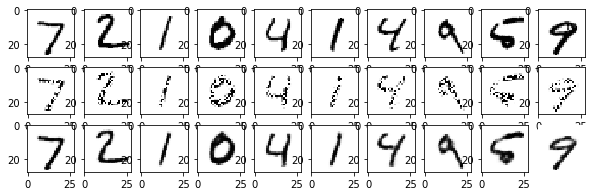

In [7]:
x_test_noise = making_noise(x_test[0:100], corruption_proba)
x_test_DAE = DAE_model(x_test_noise)
x_test_DAE = x_test_DAE.detach().numpy()
x_test_noise = x_test_noise.numpy()
f, a = plt.subplots(3, 10, figsize=(10, 3))
plt.axis('off')
for i in range(10):
    a[0][i].imshow(np.reshape(x_test[i], (28, 28)), cmap='Greys',  interpolation='nearest')
    a[1][i].imshow(x_test_noise[i].reshape(28, 28), cmap='Greys',  interpolation='nearest')
    a[2][i].imshow(x_test_DAE[i].reshape(28, 28), cmap='Greys',  interpolation='nearest')
plt.show()


In [0]:
def autoencoder_data(tensor_data):
  return DAE_model(making_noise(tensor_data, corruption_proba))


In [9]:
x_test = autoencoder_data(x_test)
y_test = mnist.test.labels
test_BS = len(x_test)// (num_labelled//train_BS)

y_test = torch.from_numpy(y_test.argmax(1)).type(torch.LongTensor) 
test = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_BS, shuffle = True, num_workers = 8)

del x_test, y_test, x_trainall, y_trainall, trainall, trainall_loader
gc.collect()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


153

Labeled data size : (100, 784)
Unlabeled data size : (54900, 784)
Proportion of class label in train data: 
    0   1   2   3   4  5   6   7   8   9
0   0   1   2   3   4  5   6   7   8   9
1  10  11  10  10  10  9  10  10  10  10


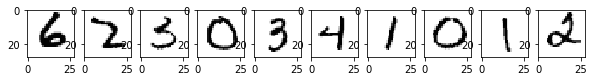

[6 2 3 0 3 4 1 0 1 2]


In [10]:
def random_data_generator(nb_PLdata = False):
  stratSplit = StratifiedShuffleSplit(test_size=100, n_splits=1)
  stratSplit.get_n_splits(mnist.train.images, np.argmax(mnist.train.labels, axis = 1))
  for train_index, test_index in stratSplit.split(X = mnist.train.images,y = mnist.train.labels):
    x_train = mnist.train.images[test_index]
    y_train = mnist.train.labels[test_index]
    if nb_PLdata == False :
      x_PL = mnist.train.images[train_index]
    else:
      x_PL = mnist.train.images[train_index][0:nb_PLdata]
  return x_train, y_train, x_PL

x_train_viewtest, y_train_viewtest, x_PL_viewtest = random_data_generator()
print('Labeled data size :', x_train_viewtest.shape)
print('Unlabeled data size :', x_PL_viewtest.shape)
print('Proportion of class label in train data: ')

print(pd.DataFrame(np.unique(np.argmax(y_train_viewtest,1), return_counts = True)).to_string())

f, a = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    a[i].imshow(np.reshape(x_train_viewtest[i], (28, 28)), cmap='Greys',  interpolation='nearest')
plt.show()

print(y_train_viewtest[0:10].argmax(1))

In [0]:
def data_build(nb_PLdata = False):
  x_train, y_train, x_PL = random_data_generator(nb_PLdata)
  x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
  y_train = torch.from_numpy(y_train.argmax(1)).type(torch.LongTensor) 

  x_PL = torch.from_numpy(x_PL).type(torch.FloatTensor)

  train = torch.utils.data.TensorDataset(x_train, y_train)
  train_loader = torch.utils.data.DataLoader(train, batch_size = train_BS, shuffle = True, num_workers = 8)

  unlabeled = torch.utils.data.TensorDataset(x_PL)
  unlabeled_loader = torch.utils.data.DataLoader(unlabeled, batch_size = unlabel_BS, shuffle = True, num_workers = 8)

  return train_loader, unlabeled_loader

In [0]:
class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
    
            self.fc1 = nn.Linear(inputN, hiddenN)
            self.fc2 = nn.Linear(hiddenN, hiddenN2)
            self.fc3 = nn.Linear(hiddenN2, hiddenN3)
            self.fc4 = nn.Linear(hiddenN3, outputN)
            self.log_softmax = nn.LogSoftmax(dim = 1)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.dropout(x, training=self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, training=self.training)
            x = F.relu(self.fc3(x))
            x = F.dropout(x, training=self.training)
            x = F.relu(self.fc4(x))
            x = self.log_softmax(x)
            return x

Now let's define a function to evaluate the network and get loss and accuracy values. 

In [0]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0 
    loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.cuda()
            output = model(data)
            predicted = torch.max(output,1)[1]
            correct += (predicted == labels.cuda()).sum()
            loss += F.nll_loss(output, labels.cuda()).item()

    return (float(correct)/len(test)) *100, (loss/len(test_loader))

First, let's train the model on the labeled set for 300 epochs

In [0]:
def train_supervised(model, train_loader, test_loader, verbose_step = 10):
    test_acc_list = []
    test_loss_list = []
    optimizer = torch.optim.SGD( model.parameters(), lr = 0.1)
    model.train()
    begin = time.time()
    for epoch in tqdm_notebook(range(trainingEpochs)):
        correct = 0
        running_loss = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = autoencoder_data(X_batch).cuda(), y_batch.cuda()
            
            output = model(X_batch)
            labeled_loss = F.cross_entropy(output, y_batch)
                       
            optimizer.zero_grad()
            labeled_loss.backward()
            optimizer.step()
            running_loss += labeled_loss.item()
        
        if (epoch+1) %verbose_step == 0 or epoch ==0:
            test_acc, test_loss = evaluate(model, test_loader)
            test_acc_list.append(test_acc)
            test_loss_list.append(test_loss)
            print('Epoch: {} : Time = {:.2f} | Train Loss = {:.3f} | Test Acc = {:.3f} | Test Loss= {:.3f} '.
                  format(epoch+1,time.time()-begin, running_loss/(10 * num_labelled), test_acc, test_loss))
            model.train()
    return test_acc_list, test_loss_list    

In [0]:
def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

In [0]:
def semisup_train(model, train_loader, unlabeled_loader, test_loader, verbose_step = 10):
    alpha_list = []
    test_acc_list = []
    test_loss_list = []
    begin = time.time()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1,)
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 0 

    model.train()
    for epoch in tqdm_notebook(range(PLtrainingEpochs)):
        for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled = autoencoder_data(x_unlabeled[0]).cuda()
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * F.cross_entropy(output, pseudo_labeled)   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()

            # For every 50 unlabeled batches train one epoch on labeled data 
            if batch_idx % 50 == 0:
              for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                  X_batch = autoencoder_data(X_batch).cuda()
                  y_batch = y_batch.cuda()
                  output = model(X_batch)
                  labeled_loss = F.cross_entropy(output, y_batch)

                  optimizer.zero_grad()
                  labeled_loss.backward()
                  optimizer.step()
                
              # Now we increment step by 1
              step += 1
                
        if (epoch+1) %verbose_step == 0 or epoch ==0:  
            test_acc, test_loss =evaluate(model, test_loader)
            print('Epoch: {} : Time = {:.2f} | Alpha Weight = {:.3f} | Test Acc = {:.3f} | Test Loss = {:.3f} '.
                  format(epoch+1, time.time()- begin, alpha_weight(step), test_acc, test_loss))
        
            """ LOGGING VALUES """
            alpha_list.append(alpha_weight(step))
            test_acc_list.append(test_acc)
            test_loss_list.append(test_loss)
        """ ************** """
        model.train()
    return alpha_list, test_acc_list, test_loss_list
 

In [0]:
def run_function(verbose_supervised = 20, verbose_unsupervised = 50) :
    train_loader, unlabeled_loader = data_build()
    print('===== Supervised training =====')
    net = Net().cuda() 
    NN_acc, NN_loss = train_supervised(net, train_loader, test_loader, verbose_supervised)

    print('===== Semi-supervised training =====')

    net = Net().cuda()
    alpha_list, PL_acc, PL_loss = semisup_train(net, train_loader, unlabeled_loader, test_loader, verbose_unsupervised)

    print('===== Conclusion =====')
    print('Supervised accuracy = ', NN_acc[-1])
    print('+PL accuracy = ', PL_acc[-1])
    return NN_acc, NN_loss, alpha_list, PL_acc, PL_loss

In [19]:
NN_acc, NN_loss, alpha_list, PL_acc, PL_loss = run_function()

===== Supervised training =====


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 : Time = 0.91 | Train Loss = 0.009 | Test Acc = 10.210 | Test Loss= 2.304 
Epoch: 20 : Time = 8.59 | Train Loss = 0.009 | Test Acc = 27.090 | Test Loss= 2.275 
Epoch: 40 : Time = 16.76 | Train Loss = 0.007 | Test Acc = 44.200 | Test Loss= 2.045 
Epoch: 60 : Time = 25.02 | Train Loss = 0.005 | Test Acc = 53.520 | Test Loss= 1.821 
Epoch: 80 : Time = 33.20 | Train Loss = 0.003 | Test Acc = 55.540 | Test Loss= 1.841 
Epoch: 100 : Time = 41.35 | Train Loss = 0.002 | Test Acc = 74.430 | Test Loss= 0.633 
Epoch: 120 : Time = 49.58 | Train Loss = 0.001 | Test Acc = 71.920 | Test Loss= 1.036 
Epoch: 140 : Time = 57.76 | Train Loss = 0.000 | Test Acc = 77.590 | Test Loss= 1.070 
Epoch: 160 : Time = 65.92 | Train Loss = 0.002 | Test Acc = 74.490 | Test Loss= 0.661 
Epoch: 180 : Time = 74.12 | Train Loss = 0.000 | Test Acc = 77.630 | Test Loss= 1.478 
Epoch: 200 : Time = 82.37 | Train Loss = 0.000 | Test Acc = 78.180 | Test Loss= 0.692 
===== Semi-supervised training =====


Epoch: 1 : Time = 12.04 | Alpha Weight = 0.000 | Test Acc = 20.860 | Test Loss = 2.307 
Epoch: 50 : Time = 593.08 | Alpha Weight = 0.250 | Test Acc = 82.630 | Test Loss = 0.664 
Epoch: 100 : Time = 1219.07 | Alpha Weight = 1.500 | Test Acc = 84.240 | Test Loss = 1.059 
Epoch: 150 : Time = 1889.92 | Alpha Weight = 2.750 | Test Acc = 80.560 | Test Loss = 1.688 
Epoch: 200 : Time = 2559.57 | Alpha Weight = 3.000 | Test Acc = 75.310 | Test Loss = 1.883 
Epoch: 250 : Time = 3247.90 | Alpha Weight = 3.000 | Test Acc = 69.360 | Test Loss = 1.928 
Epoch: 300 : Time = 3980.51 | Alpha Weight = 3.000 | Test Acc = 42.730 | Test Loss = 10.640 
Epoch: 350 : Time = 4762.97 | Alpha Weight = 3.000 | Test Acc = 19.340 | Test Loss = 4.705 
Epoch: 400 : Time = 5641.96 | Alpha Weight = 3.000 | Test Acc = 27.910 | Test Loss = 4.578 
Epoch: 450 : Time = 6697.05 | Alpha Weight = 3.000 | Test Acc = 20.540 | Test Loss = 7.437 
Epoch: 500 : Time = 7481.99 | Alpha Weight = 3.000 | Test Acc = 20.830 | Test Loss = 

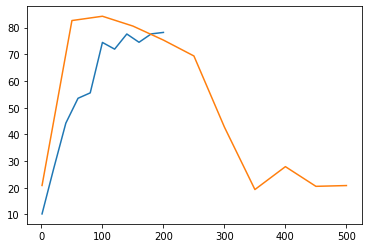

In [20]:
plt.clf()
plt.plot(np.append(1,np.arange(20,201,20)), NN_acc)
plt.plot(np.append(1,np.arange(50,501,50)), PL_acc)

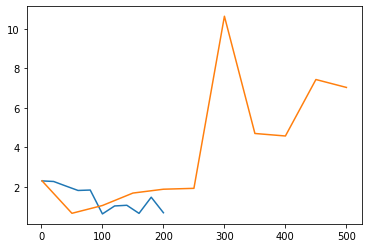

In [21]:
plt.clf()
plt.plot(np.append(1,np.arange(20,201,20)), NN_loss)
plt.plot(np.append(1,np.arange(50,501,50)), PL_loss)